In [2]:
import numpy
import matplotlib.patches as patches
from matplotlib import colors
import mitsuba as mi
mi.set_variant("cuda_ad_rgb")
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.patches import Polygon
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *
import matplotlib.patches as patches
from PDE2D.utils.helpers import *

In [ ]:
from mitsuba import Point2i

In [4]:
rad = 1.2
electrode_holder = CircleWithElectrodes(num_electrodes = 8, is_delta = False, electrode_length=0.2, radius = rad, injection_confs=[[0,5]], centered = False)

NameError: name 'Array2i' is not defined

In [3]:
dirichlet = ConstantCoefficient("dirichlet", 1)
neumann = ConstantCoefficient("neumann", 2)
dirichlet_map = np.array([False])
shape = CircleShape(origin = mi.Vector2f(0.,0.), radius = rad, name = "in-boundary", epsilon = 0.1,
                       dirichlet=dirichlet, neumann = neumann, dirichlet_map = dirichlet_map)

in_shape = CircleShape(origin = mi.Vector2f(0.2, 0.0), radius = 0.2)
shape_holder = ShapeHolderDiscrete(in_shape=in_shape, out_shape = shape)


In [4]:
bbox = [[-1.21 * rad,-1.21 * rad], [1.21 * rad,1.21 * rad]]
resolution = [1024,1024]
image = np.zeros(resolution)

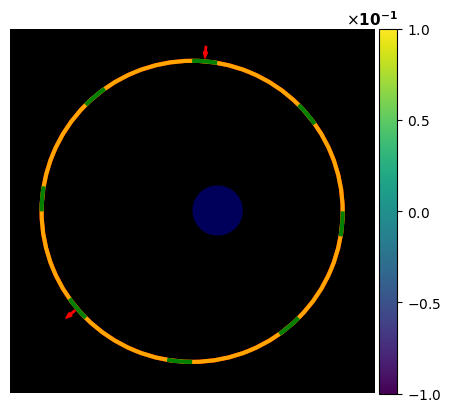

In [5]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
plot_image(image, ax)
shape_holder.sketch(ax, bbox, resolution)
electrode_holder.sketch(ax, bbox, resolution, conf_number = 0)


In [6]:
r = rad;
on_boundary = mi.Bool(True)
num_points = 1
theta = 200
theta = theta * dr.pi / 180
theta = np.linspace(0,2*np.pi * (num_points-1)/ num_points,num_points) + np.pi/10
x = r * np.sin(theta)
y = r * np.cos(theta)
points = mi.Vector2f(x, y)
boundary_points = mi.Vector2f(dr.sin(mi.Float(theta)), dr.cos(mi.Float(theta)))
indices = np.arange(num_points)
bi, in_mask = shape_holder.boundary_interaction(points);

In [7]:
bi.is_star

[True]

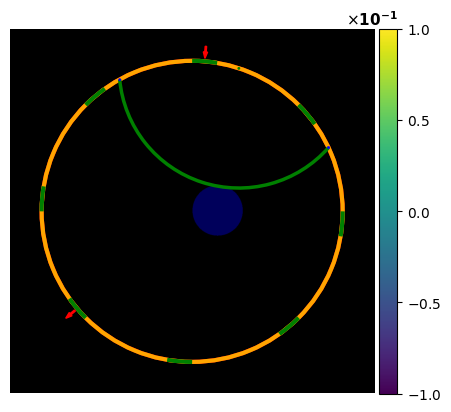

In [8]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
plot_image(image, ax)
shape_holder.sketch(ax, bbox, resolution)
electrode_holder.sketch(ax, bbox, resolution, conf_number=0)
bi.sketch_stars(ax, indices, bbox, resolution)

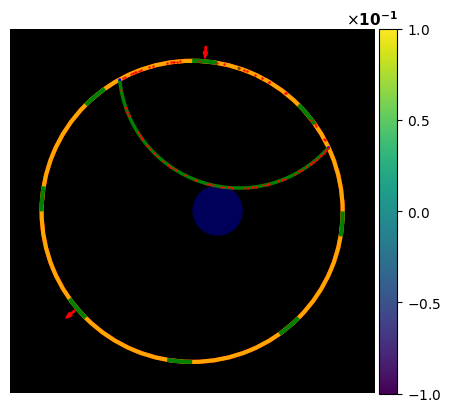

In [9]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
plot_image(image, ax)
shape_holder.sketch(ax, bbox, resolution)
electrode_holder.sketch(ax, bbox, resolution, conf_number = 0)
bi.sketch_stars(ax, indices, bbox, resolution)
sampler = mi.load_dict({'type':'independent'})
sampler.seed(1, num_points)
for i in range(100):
    sampled_dir, sphere_p, pdf_rec_r = bi.sample_recursive(sampler.next_float32())
    dist_ray, intersected, normals = shape_holder.ray_intersect(bi, sampled_dir)
    on_boundary_next = bi.is_star & (dist_ray <= bi.r)
    sampled_point = dr.select(bi.is_star & on_boundary_next, intersected, sphere_p)
    sampled_point = point2sketch(sampled_point, bbox, resolution).numpy() 
    ax.scatter(sampled_point[:,0] - 0.5, sampled_point[:,1] - 0.5, color = "red", s=0.5)

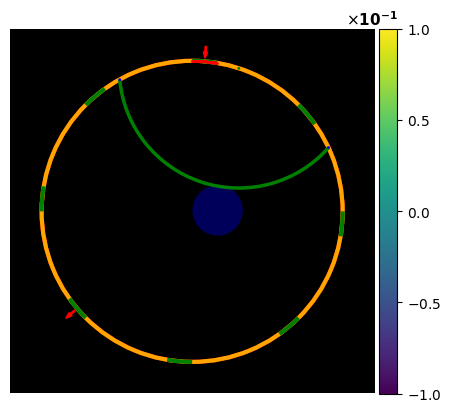

In [10]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
plot_image(image, ax)
shape_holder.sketch(ax, bbox, resolution)
electrode_holder.sketch(ax, bbox, resolution, conf_number = 0)
bi.sketch_stars(ax, indices, bbox, resolution)
sampler = mi.load_dict({'type':'independent'})
sampler.seed(1, num_points)
for i in range(100):
    distance, neumann, pdf_r, sampled_point= electrode_holder.sample_electrode(bi, sampler.next_float32(),  injected = True, conf_number=0)
    sampled_point = point2sketch(sampled_point, bbox, resolution).numpy() 
    ax.scatter(sampled_point[:,0] - 0.5, sampled_point[:,1] - 0.5, color = "red", s=0.5)